In [29]:
import cv2
import numpy as np

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show(*images):
    for i in images:
        image = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()


# Feature extraction

## Scale Invariant Feature Trasform

It does not depend on rescaling, rotation and small perturbation of brightness.  
The points are drawn where there are changes in the gradient (changes in the image).  
It is a float - providing method.

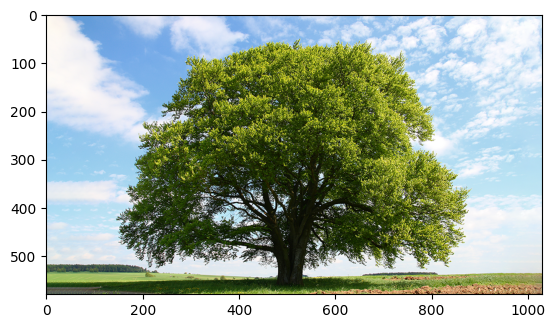

In [31]:
img = cv2.imread("samples/tree.png")
show(img)

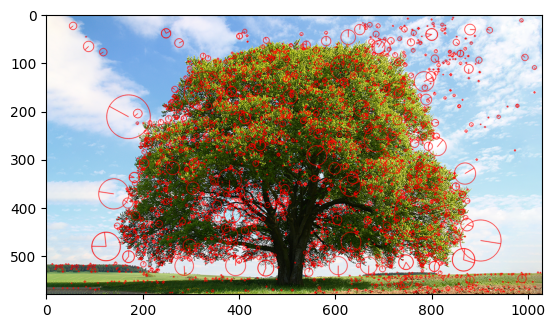

In [32]:
sift = cv2.SIFT.create()
keypoints, descriptors = sift.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)

The line inside the circle points towards the direction of the $\nabla_X$.

## SURF

A patented float-descriptor method.

In [33]:
'''
surf = cv2.xfeatures2d.SURF.create()
keypoints, descriptors = surf.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (128, 128, 128), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)
'''

'\nsurf = cv2.xfeatures2d.SURF.create()\nkeypoints, descriptors = surf.detectAndCompute(img, None)       #a mask can be specified\ncv2.drawKeypoints(img, keypoints, img, (128, 128, 128), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\n#the last flag specifies how much info to keep for keypoints\nshow(img)\n'

## A-Kaze

A binary-descriptor method. Most of the times, the same image will result in the same keypoints and descriptors.

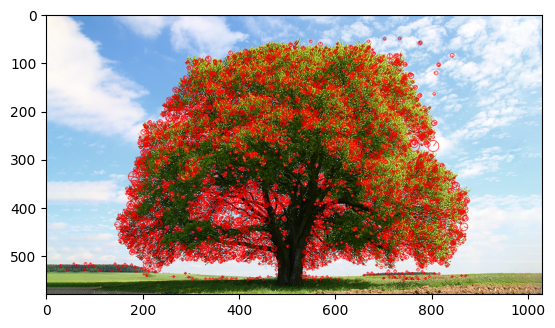

In [34]:
img = cv2.imread("samples/tree.png")
akaze = cv2.AKAZE_create()
keypoints, descriptors = akaze.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)

# Drawing keypoints
Note that the perspective transform needs *at least* 4 points, but providing more will work just as fine.

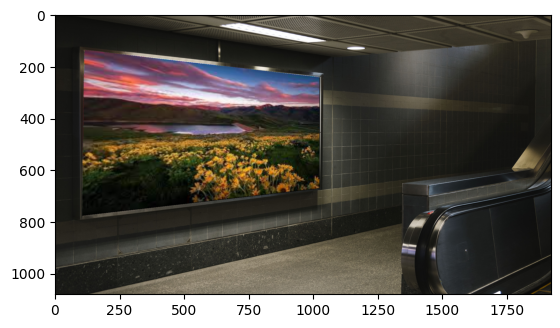

In [35]:
img1 = cv2.imread("samples/landscapebillboard.png")
show(img1)

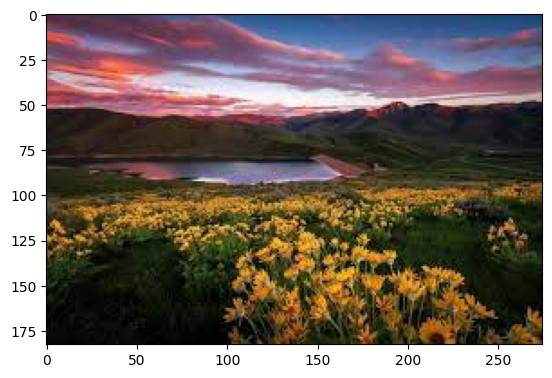

In [36]:
img2 = cv2.imread("samples/landscape.jpeg")
show(img2)

In [37]:
akaze = cv2.AKAZE.create()
kpts1, dscpt1 = akaze.detectAndCompute(img1, None)
kpts2, dscpt2 = akaze.detectAndCompute(img2, None)

The keypoints with the smaller distances should correspond and be the same.  
We compute matches between the two sets of keypoints.

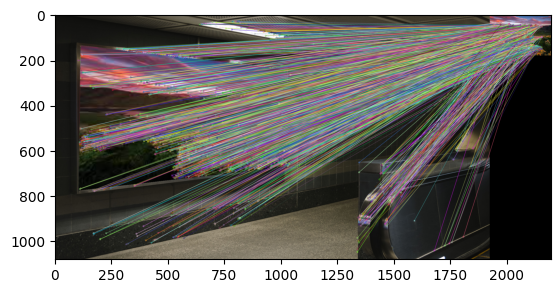

In [38]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)     #bruteforce matcher
matches = bf.match(dscpt1, dscpt2)

img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, matches, img2, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)     #we may have keypoints that are not matched with anything
show(img_matches)

Matches can be performed through the *K Nearest Neighbour* algorithm.

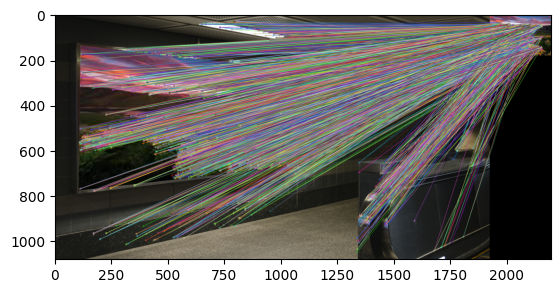

In [39]:
img2 = cv2.imread("samples/landscape.jpeg")
bf = cv2.BFMatcher(cv2.NORM_HAMMING)     #bruteforce matcher
matches = bf.knnMatch(dscpt1, dscpt2, k = 2)

img_matches = cv2.drawMatchesKnn(img1, kpts1, img2, kpts2, matches, img2, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)     #we may have keypoints that are not matched with anything
show(img_matches)

# Panorama

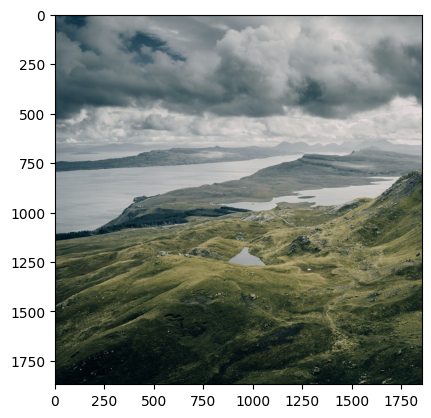

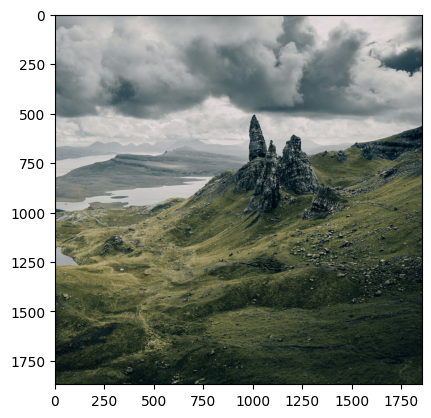

In [40]:
import cv2
import numpy as np

img1 = cv2.imread("samples/left.png")
img2 = cv2.imread("samples/right.png")

show(img1)
show(img2)

Now, we can use a feature extractor to pick the common points.

In [49]:
orb = cv2.ORB.create()
kpts1, dscpt1 = orb.detectAndCompute(img2, None)
kpts2, dscpt2 = orb.detectAndCompute(img1, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = matcher.knnMatch(dscpt1, dscpt2, k=2)

print("Done")

Done


Let's get rid of false positives through the **ratio test**:  
If the ratio between the neighbours is above a certain number, it means that the feature is not relevant (?) and thus the match is discarded. The threshold is set by us.

In [50]:
good_matches = []
for m, n in matches:
    if m.distance < 0.3 * n.distance:
        good_matches.append(m)

Now, we need to compute the homography matrix, since the panorama is often built by moving the sensor *and it perspective*.  
Affine transformations are not enough.

In [51]:
#We must check if we have at least 4 points.

if len(good_matches) >= 4:
    #convert the points to an homography matrix
    #convert the points to float32
    src_points = np.float32([kpts1[m.queryIdx].pt for m in good_matches])
    #queryImg is the left image, while trainImg is the right image.
    #queryIdx is a point belonging to the left image.
    dst_points = np.float32([kpts2[m.trainIdx].pt for m in good_matches])

#compute the homography matrix

M, mask = cv2.findHomography(src_points, dst_points)

Now, we transform the left image and stick it together with the right image.  
Note that when we stick two images together on a larger image with the horizontal dimension as big as the sum of the two, there is a little gap due to the fact that a portion of the two images is overlapping.

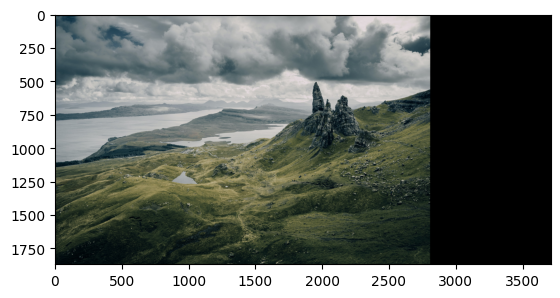

In [53]:
dst = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img1.shape[0]))
dst[0:img1.shape[0], 0:img1.shape[1]] = img1.copy()
show(dst)

Note that we could even use affine transformations instead of homograpy transformations in this case - there is just translation between the two pictures.

Now, we can try to remove the black pixels from the final image.  
Since the last column of the homography matrix contains the translation part of the affinity transformations, it is possible to extract the translation from that in order to delete the black pixels.

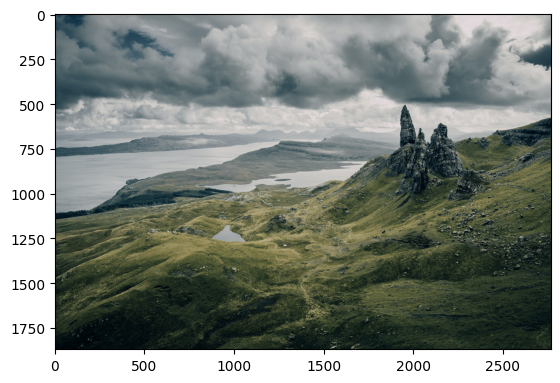

In [55]:
dst = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1] - int(M[0, 2]), img1.shape[0]))
dst[0:img1.shape[0], 0:img1.shape[1]] = img1.copy()
show(dst)